## 1D Transient Heat Conduction, Fully Implicit Finite Volume Method
### Background

A very brief explanation of how this solver works. Skip to Equation 6 to see the final result.

#### 1D Transient Heat Conduction 
\begin{equation}\rho c\frac{\partial T}{\partial t}=\frac{\partial}{\partial x}(k \frac{\partial T}{\partial x}) + S\tag{1}\end{equation}

Where $T$ is temperature, $rho$ is density, $c$ is specific heat, $k$ is thermal conductivity, and $S$ is the source term.

Given a uniform grid with spacing, $\Delta x$, with $P$ as the $i$th node, $W$ as the $i-1$ node, and $E$ is the $i+1$ node, $T^{0}_{P}$ is the temperature at the $i$th node for the current timestep, the the heat equation can be discretized as:

\begin{equation}a_PT_P = a_WT_W + a_ET_E + a^{0}_{P}T^{0}_{P} + S_u\tag{2}\end{equation}

Where

\begin{equation}a_P = a_W + a_E + a^{0}_{P} - S_p\tag{3}\end{equation}

And the transient terms

\begin{equation}a^{0}_{P} = \rho c \frac{\Delta x}{\Delta t}\tag{4}\end{equation}

And the linearized boundary terms

\begin{equation}S_u = T_{boundary} \frac{2k}{\Delta x}, S_p = -\frac{2k}{\Delta x}\tag{5}\end{equation}

Rearranging Equation 2 yields:
\begin{equation}-a_WT_W + a_PT_P -a_ET_E = a^{0}_{P}T^{0}_{P} + S_u\tag{6}\end{equation}

Where $a = \frac{k}{\Delta x}$

#### 1D Transient Heat Conduction - Example

If you setup the system of equations in Equation 5, it will yield a tridiagonal matrix, with $-a_E$ as the upper diagonal, $a_P$ as the main diagonal, and $-a_W$ as the lower diagonal.

Consider a five-node system, with an adibatic boundary to the left of Node 1 and a Dirichlet boundary condition to the right of Node 5.

$$\begin{bmatrix} \frac{k}{\Delta x} + \rho c \frac{\Delta x}{\Delta t} & -\frac{k}{\Delta x} & 0 & 0 & 0 \\ -\frac{k}{\Delta x} & \frac{2k}{\Delta x} 
+\rho c \frac{\Delta x}{\Delta t} & -\frac{k}{\Delta x} & 0 & 0 \\ 0 & -\frac{k}{\Delta x} & \frac{2k}{\Delta x} + \rho c \frac{\Delta x}{\Delta t} & -\frac{k}{\Delta x} & 0 \\ 0 & 0 & -\frac{k}{\Delta x} & \frac{2k}{\Delta x} + \rho c \frac{\Delta x}{\Delta t}  & -\frac{k}{\Delta x} \\ 0 & 0 & 0 & -\frac{k}{\Delta x} & \frac{k}{\Delta x} + \rho c \frac{\Delta x}{\Delta t} - S_p \end{bmatrix} \begin{bmatrix} T_1 \\ T_2 \\ T_3 \\ T_4 \\ T_5\end{bmatrix} = \begin{bmatrix} a^{0}_{P}T^{0}_{1} \\ a^{0}_{P}T^{0}_{2} \\ a^{0}_{P}T^{0}_{3} \\ a^{0}_{P}T^{0}_{4} \\ a^{0}_{P}T^{0}_{5} + S_u\end{bmatrix}$$

For each timestep, solve for $\vec{T}$. Because this method will always yield a tridiagonal matrix, the __[TDMA Algorithm](https://en.wikipedia.org/wiki/Heat_transfer_coefficient)__ is the most computationally efficient way to solve this system, with a time complexity of $O(n)$. Since Python is an interpreted language, it's better to call a compiled LAPACK subroutine to do this.

In SciPy, I use the __[linalg.lapack.dgtsv()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lapack.dgtsv.html)__ method to solve the tridiagonal system.

#### Python Code

Consider a 100 mm aluminum rod at $300^{\circ}C$. At t = 0, One end is fixed at $T_a = 25^{\circ}C$ and the other end is fixed at $T_b = 100^{\circ}C$. All other surfaces are adiabatic. Analyze the temperature distribution over the next 100 seconds.

Setup the grid with 100 nodes, where $\Delta x = 1 mm$.
$$\rho = 2770 kg/m^{3}$$
$$c = 986 J/kg K$$
$$k = 175 W/m K$$

Because the solver is fully implicit, it is unconditionally stable. This means that the user must choose a small enough timestep to ensure simulation accuracy.

Let $\Delta t = 1 s$.


In [11]:
#  1D Implicit Finite Volume Heat Transfer Solver
#  Fully implicit. Unconditionally stable, so choose an appropriate value for dt.
#  Source terms use a linear approximation.
#  Reference: An Introduction to Computational Fluid Dynamics. Versteeg et al.

import numpy as np
import scipy.linalg as linalg


def setup_matrix(k, pc, dt, dx, x_len, Ta, Tb):
    """
Setup matrix diagonals representing the thermal system.
    :param k: Thermal conductivity (W/m*K)
    :param pc: Volumetric specific heat (J/m^3*K)
    :param dt: Timestep (s)
    :param dx: Grid step size in x (m)
    :param x_len: Total number of nodes
    :param Ta: Leftmost boundary condition (deg. C)
    :param Tb: Rightmost boundary condition (deg. C)
    :return: Matrix diagonals and source term.
    """
    # Construct tridiagonal matrix
    alpha = np.zeros(x_len)  # Upper diagonal
    D = np.zeros(x_len)  # Main diagonal
    beta = np.zeros(x_len)  # Lower diagonal
    Su = np.zeros(x_len)  # Linearized source term

    # Iterate through domain and setup nodal coefficients and source terms
    for x in range(x_len):
        # Heat transfer coefficient for node to the West of the ith node
        aw = 0
        if x > 0:
            aw = k / dx

        # Heat transfer coefficient for node to the East of the ith node
        ae = 0
        if x < x_len - 1:
            ae = k / dx

        # Transient term
        ap0 = pc * (dx / dt)

        # Linear approximation of source term
        Sp = 0
        if x == 0:  # Check if we're at a boundary
            if Ta is not None:  # Check if adiabatic
                Sp = -2 * k / dx
                Su[x] = Ta * 2 * k / dx
        elif x == x_len - 1:
            if Tb is not None:
                Sp = -2 * k / dx
                Su[x] = Tb * 2 * k / dx

        # Heat transfer coefficient for the ith node
        ap = aw + ae + ap0 - Sp

        # Diagonals for tridiagonal system
        alpha[x] = -ae
        D[x] = ap
        beta[x] = -aw

    # Add leading and trailing zeros to upper and lower diagonals
    # alpha = np.insert(alpha, 0, 0.0)[:-1]
    # beta = np.append(beta, 0.0)[1:]
    alpha = alpha[:-1]
    beta = beta[1:]

    return alpha, D, beta, Su


def solve_tridiagonal_system(upper, main_diag, lower, b):
    """
Solves a system of Ax=b, where A is a tridiagonal matrix.
    :param upper: Upper diagonal
    :param main_diag: Main diagonal
    :param lower: Lower diagonal
    :param b: Right-hand-side of the equation
    :return: x, where x is a vector
    """
    temp = linalg.lapack.dgtsv(lower, main_diag, upper, b)

    # Only want x
    return temp[3]


def main():
    """
Main loop.
    """

    # Print out every timestep
    verbose = False
    
    t_max = 100.0  # Total simulation time, seconds
    dt = 1  # Timestep, seconds. NOTE: Implicit solver is unconditionally stable!

    k = 175  # Thermal conductivity, W/m*K
    p = 2770  # Density, kg/m^3
    c = 986  # Specific heat, J/kg*K

    x_len = 100  # Number of nodes
    dx = 0.001  # Distance between nodes, m

    initial_temperature = 300.0  # deg. C

    # Boundary conditions. NoneType means adiabatic boundary.
    Ta = 25.0  # Western boundary, deg. C
    Tb = 100.0  # Eastern boundary, deg. C

    n_iterations = int(t_max / dt) + 1

    pc = p * c  # Volumetric specific heat, J/m^3*K

    # Initialize grid
    temperature = np.zeros((n_iterations, x_len)) + initial_temperature
    temperature = temperature.tolist()

    # Generate diagonals for sparse matrix
    alpha, D, beta, Su = setup_matrix(k, pc, dt, dx, x_len, Ta, Tb)

    # Start solving for each timestep
    C = np.zeros(x_len)
    for t in range(1, n_iterations):
        for x in range(x_len):
            C[x] = pc * dx / dt * temperature[t - 1][x] + Su[x]

        temperature[t] = solve_tridiagonal_system(alpha, D, beta, C)
        
        if verbose:
            print('t=%d' % (t * dt,), temperature[t])

    return temperature


if __name__ == '__main__':
    t = main()


#### Graphing Results

Let's graph the results:

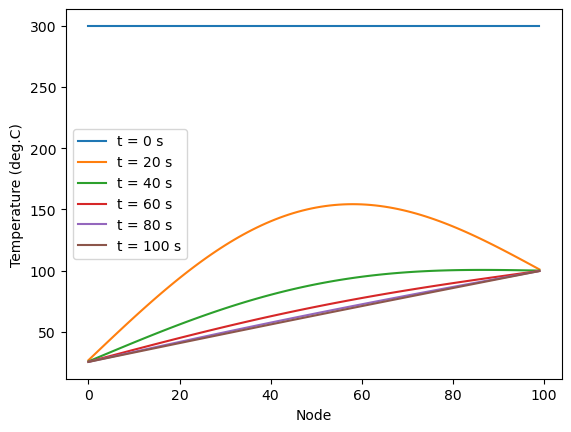

In [10]:
import matplotlib.pyplot as plt

# Plot temperature curve in 20-second intervals
plt.plot(t[0], label='t = 0 s')
plt.plot(t[20], label='t = 20 s')
plt.plot(t[40], label='t = 40 s')
plt.plot(t[60], label='t = 60 s')
plt.plot(t[80], label='t = 80 s')
plt.plot(t[100], label='t = 100 s')
plt.xlabel('Node')
plt.ylabel('Temperature (deg.C)')
plt.legend()
plt.show()

#### Discussion and Validation
These results make sense intuitively. To be completely sure that this model is programmed correctly, let's compare against a commercial solver.

### References
*An Introduction to Computational Fluid Dynamics, 2nd Ed.* H. Versteeg and W. Malalasekra, 2007.